# PROYECTO FINAL

**Desarrollado por:**  
Johan Díaz  
Héctor Sanjuan  
Miguel Lugo  
Luis David Peñaranda

---

## Índice
    1. Análisis Exploratorio de Datos (EDA)
        1.1. Carga de los datos 
        1.2. Análisis de los datos 
            1.2.1 Datos faltantes
        1.3. Visualización de la variable objetivo
        1.4  Análisis univariado de las variables numéricas 
        1.5. Variables numéricas vs. target  
        1.6  Variables categóricas vs. Target 
        1.7. Correlación  
        1.8. Conclusión del Análisis Exploratorio de Datos

    2. Modelo de regresión logística
        2.1 Búsqueda del mejor parámetro
        2.2 Implementación del modelo con el mejor parámetro y métricas de evaluación
        2.3 Conclusiones del modelo

    3. Modelo k-NN
        3.1 Búsqueda del mejor parámetro 
        3.2 Implementación del modelo con el mejor parámetro y métricas de evaluación
        3.3 Conclusiones del modelo
        3.4 Modelo sin balanceo




## 1. Análisis Exploratorio de Datos (EDA)

Esta etapa nos permitirá comprender mejor la distribución de las variables, identificar patrones, relaciones entre características, y posibles diferencias entre los grupos de estudio. El objetivo es obtener información relevante que nos oriente en la construcción y evaluación de los modelos predictivos.

### 1.1. Carga de los datos

Para empezar, necesitamos cargar los datos. Para que este notebook lo pueda usar cualquiera sin descargar archivos manualmente, hemos creado una función que se conecta a un link de GitHub, baja un archivo `.zip`, lo descomprime y carga el archivo `.csv` que tiene adentro. Así el proceso es automático y fácil.

In [151]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

sns.set_style('whitegrid')
plt.style.use('seaborn-v0_8-deep')

import requests
import zipfile
from io import BytesIO

from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import precision_recall_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, average_precision_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier



def load_health_data():
    PERMANENT_LINK = "https://github.com/johand-lopez/eda_ml/blob/8530ff0aaf5e5d556e3994c15e45f576b629bcde/data.zip"
    RAW_LINK = PERMANENT_LINK.replace("github.com", "raw.githubusercontent.com").replace("/blob/", "/")

    try:
        print(f"Descargando desde: {RAW_LINK}")
        response = requests.get(RAW_LINK, timeout=10)
        response.raise_for_status()  
        
        with zipfile.ZipFile(BytesIO(response.content)) as z:
            csv_name = [f for f in z.namelist() if f.endswith('.csv')][0]
            with z.open(csv_name) as f:
                print(f" Archivo '{csv_name}' cargado correctamente")
                return pd.read_csv(f,  na_values=[""], keep_default_na=False)
    
    except Exception as e:
        print(f"Error durante la carga: {str(e)}")
        print("\nSolución de problemas:")
        print(f"1. Verifica que el enlace sea accesible: {RAW_LINK}")
        print("2. Asegúrate que el ZIP contiene un CSV")
        print("3. Revisa tu conexión a internet")
        return None

df = load_health_data()

if df is None:
    raise SystemExit("No se pudo cargar el dataset. Detén la ejecución y revisa el enlace o tu conexión.")

Descargando desde: https://raw.githubusercontent.com/johand-lopez/eda_ml/8530ff0aaf5e5d556e3994c15e45f576b629bcde/data.zip
 Archivo 'health_lifestyle_classification.csv' cargado correctamente


Los parámetros dados a `read_csv` son necesarios para que en las variables `alcohol_consumption`, `caffeine_intake` y `exercise_type` no se tomen las categorías None como valores faltantes. En el caso de esta base de datos, los valores faltantes solo son las celdas vacías.

### 1.2. Análisis de los datos

En esta sección inspeccionamos las primeras filas y el tipo de variables. Esta información nos permite identificar posibles problemas de calidad de los datos y tomar decisiones informadas sobre el preprocesamiento.


Ahora que los datos están cargados, vamos a hacer una revisión rápida para empezar a conocer los datos.

In [152]:
print("\nVista previa del DataFrame:")
df.head()



Vista previa del DataFrame:


,survey_code,age,gender,height,weight,bmi,bmi_estimated,bmi_scaled,bmi_corrected,waist_size,...,sunlight_exposure,meals_per_day,caffeine_intake,family_history,pet_owner,electrolyte_level,gene_marker_flag,environmental_risk_score,daily_supplement_dosage,target
0,1,56,Male,173.416872,56.886640,18.915925,18.915925,56.747776,18.989117,72.165130,...,High,5,Moderate,No,Yes,0,1.0,5.5,-2.275502,healthy
1,2,69,Female,163.207380,97.799859,36.716278,36.716278,110.148833,36.511417,85.598889,...,High,5,High,Yes,No,0,1.0,5.5,6.239340,healthy
2,3,46,Male,177.281966,80.687562,25.673050,25.673050,77.019151,25.587429,90.295030,...,High,4,Moderate,No,No,0,1.0,5.5,5.423737,healthy
3,4,32,Female,172.101255,63.142868,21.318480,21.318480,63.955440,21.177109,100.504211,...,High,1,None,No,Yes,0,1.0,5.5,8.388611,healthy
4,5,60,Female,163.608816,40.000000,14.943302,14.943302,44.829907,14.844299,69.021150,...,High,1,High,Yes,Yes,0,1.0,5.5,0.332622,healthy


In [153]:
print("Resumen técnico del DataFrame:")
df.info()

Resumen técnico del DataFrame:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   survey_code               100000 non-null  int64  
 1   age                       100000 non-null  int64  
 2   gender                    100000 non-null  object 
 3   height                    100000 non-null  float64
 4   weight                    100000 non-null  float64
 5   bmi                       100000 non-null  float64
 6   bmi_estimated             100000 non-null  float64
 7   bmi_scaled                100000 non-null  float64
 8   bmi_corrected             100000 non-null  float64
 9   waist_size                100000 non-null  float64
 10  blood_pressure            92331 non-null   float64
 11  heart_rate                85997 non-null   float64
 12  cholesterol               100000 non-null  float64
 13  glucose       

En la primera etapa de nuestro Análisis Exploratorio de Datos (EDA), examinamos la estructura general del conjunto de datos.

-   **Tamaño del conjunto de datos:** Descubrimos que el conjunto de datos contiene 100,000 registros y 48 variables.
-   **Tipos de datos:** Encontramos que las variables se dividen en tipos numéricos (`float64`, `int64`) y categóricos (`object`). 
-   **Valores faltantes:** Un hallazgo crucial es la presencia de valores nulos o faltantes en varias columnas. 


In [154]:
print("\nResumen de las variables numéricas:")
display(df.describe().T)


Resumen de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
survey_code,100000.0,50000.500000,28867.657797,1.000000,25000.750000,50000.500000,75000.250000,100000.000000
age,100000.0,48.525990,17.886768,18.000000,33.000000,48.000000,64.000000,79.000000
height,100000.0,170.023707,9.982798,140.000000,163.306615,170.016778,176.728920,210.000000
weight,100000.0,70.064862,14.693667,40.000000,59.856938,69.924141,80.027418,139.250894
bmi,100000.0,24.493876,5.951069,9.988495,20.271405,24.156734,28.258696,59.234792
bmi_estimated,100000.0,24.493876,5.951069,9.988495,20.271405,24.156734,28.258696,59.234792
bmi_scaled,100000.0,73.481627,17.853206,29.965484,60.814215,72.470201,84.776088,177.704377
bmi_corrected,100000.0,24.494140,5.954184,9.893845,20.271059,24.151699,28.247648,59.142646
waist_size,100000.0,84.933043,12.040314,34.093185,76.795185,84.957139,93.018713,133.153631
blood_pressure,92331.0,119.980149,15.015503,59.128168,109.812060,119.951794,130.120621,184.439195


A partir de la tabla de estadísticas descriptivas (describe), realizamos las siguientes observaciones:

1.  **Valores Faltantes (Nulos):**
    -   Confirmamos la presencia de valores faltantes en `blood_pressure`, `heart_rate`, `insulin`, `daily_steps`, `income` y `gene_marker_flag`.

2.  **Identificación de Datos Inconsistentes:**
    -   Descubrimos valores imposibles en algunas variables:
        -   `insulin`,`sugar_intake` y `daily_supplement_dosage` tienen valores mínimos negativos (-6.794483, -27.88 y -9.99, respectivamente), lo cual es un claro error de datos. Estos valores deberán ser eliminados o corregidos.
    -   Observamos la distribución de otras variables:
        -   `income` muestra un rango muy amplio, con un mínimo de 500 y un máximo de 1.2 millones. Esto indica una alta variabilidad en los ingresos y podría haber valores atípicos que necesiten ser examinados.
        -   `screen_time` tiene un mínimo de 0.5 horas y un máximo de 16 horas. La media (6.02) y la mediana (5.0) están cerca, pero el máximo sugiere que algunos individuos pasan una cantidad de tiempo en pantalla significativamente alta.

3.  **Distribución de las Variables:**
    -   Las variables `stress_level` y `mental_health_score` (ambas en una escala de 0 a 10) tienen una media de aproximadamente 5, lo que indica que los datos están bastante centrados en la mitad de la escala.
    -   Variables como `age`, `height`, `weight` y `bmi` tienen rangos y distribuciones que parecen ser razonables, lo que nos da confianza en la calidad de estos datos.

4. **Variables con características especiales:**
    -   `survey_code` hace de ID, por lo que no tiene sentido analizarla.
    -   Las variables `bmi` y `bmi_estimated` tienen exactamente la misma media y los mismos cuartiles, además, en el `head()` pudimos apreciar que tienen los mismos valores, por lo que esto sugiere que estas variables tienen exactamente la misma información y hay que eliminar una.
    -   Las variables `electrolyte_level`, `gene_marker_flag` y `environmental_risk_score` tienen exactamente el mismo valor para cada registro, esto lo sabemos debido a que el valor de los cuartiles nunca cambia. Por lo que, estas variables pueden ser retiradas del análisis, ya que no nos sirve de nada sumar una característica que tenga el mismo valor para todos los registros.
    


En resumen, esta exploración inicial nos ha permitido confirmar los valores faltantes y, de manera crucial, identificar problemas de calidad en los datos como los valores negativos en la ingesta de azúcar y la dosis de suplementos, y variables que pueden ser eliminadas del dataset. Estos hallazgos serán prioritarios en la etapa de limpieza y preprocesamiento de los datos.

#### 1.2.1 Datos faltantes

Veamos ahora la cantidad de datos faltantes que tenemos por variable.

Antes de eso, eliminemos las variables que no serán utilizadas en el proyecto.

In [155]:
df=df.drop(columns=['survey_code','bmi_estimated', 'electrolyte_level', 'gene_marker_flag', 'environmental_risk_score'])

Además, tomaremos como `NA` los valores negativos de las variables `insulin`,`sugar_intake` y `daily_supplement_dosage`.

In [156]:
neg_cols=['insulin', 'sugar_intake', 'daily_supplement_dosage']
for col in neg_cols:
    for i in range(len(df)):
        if df[col][i] < 0:
            df[col][i] = np.nan

In [157]:
# Cálculo de valores nulos y su porcentaje
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100

missing_df = pd.DataFrame({
    'Faltantes': missing,
    'Porcentaje (%)': missing_percent
})

# Mostrar solo las columnas con datos faltantes
missing_df = missing_df[missing_df['Faltantes'] > 0].sort_values(by='Faltantes', ascending=False)

print("\n⚠️ Resumen de valores faltantes por variable:")
print(missing_df)


⚠️ Resumen de valores faltantes por variable:
                         Faltantes  Porcentaje (%)
daily_supplement_dosage      49911          49.911
insulin                      15935          15.935
heart_rate                   14003          14.003
alcohol_consumption          13910          13.910
income                        8470           8.470
daily_steps                   8329           8.329
blood_pressure                7669           7.669
sugar_intake                   124           0.124


Luego del conteo de valores faltantes, vemos que la mayoría de variables con este tipo de valores se mantiene por debajo del 15%, sin embargo, la variable `daily_supplement_dosage` tiene aproximadamente la mitad de sus registros vacíos, lo que nos hace cuestionarnos si deberíamos seguir contanto con esta variable para el análisis.

Además, la variable `alcohol_consumption` no debe ser imputada, ya que es posible que las personas no quieran revelar qué tanto alcohol consumen, por lo que no es correcto rellenar esos valores faltantes con categorías que puede que no correspondan con el dueño. Por lo que decidimos crear una nueva categoría en ese caso llamada "DS": doesn't say por sus siglas en inglés, que significa que esa persona no registró su consumo de alcohol.

Veamos los valores faltantes de manera gráfica:

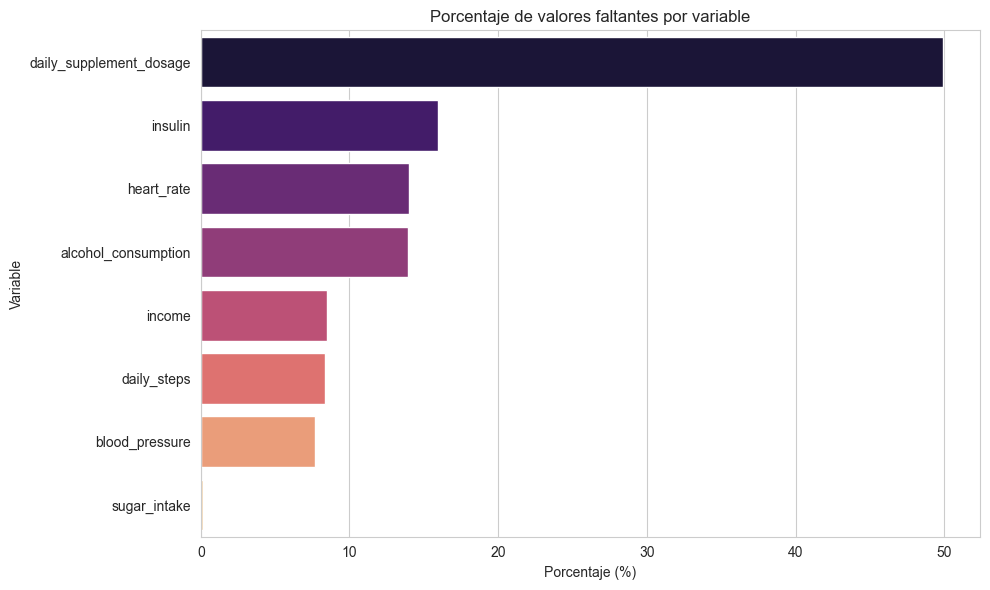

In [158]:
missing = df.isnull().sum()
missing_percent = (missing / len(df)) * 100
missing_df = pd.DataFrame({'Variable': missing.index, 'Porcentaje': missing_percent})
missing_df = missing_df[missing_df['Porcentaje'] > 0].sort_values(by='Porcentaje', ascending=False)

# Gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(data=missing_df, x='Porcentaje', y='Variable', palette='magma')
plt.title("Porcentaje de valores faltantes por variable")
plt.xlabel("Porcentaje (%)")
plt.ylabel("Variable")
plt.tight_layout()
plt.show()

#### 1.2.2 Imputación de datos faltantes

Dada la gran cantidad de valores faltantes de la variable `daily_supplement_dosage`, decidimos eliminarla del análisis para que una imputación no introduzca sesgos al tener que introducir aproximadamente la mitad de los valores de la variable.

In [159]:
df=df.drop(columns=['daily_supplement_dosage'])

Rellenamos con la categoría "DS" la variable `alcohol_consumption` como ya habíamos anticipado:

In [160]:
df["alcohol_consumption"] = df["alcohol_consumption"].fillna("DS")

In [161]:
df["alcohol_consumption"].value_counts()

alcohol_consumption
Occasionally    28831
Regularly       28782
None            28477
DS              13910
Name: count, dtype: int64

Ahora, realizemos una imputación de los valores faltantes utilizando un modelo k-NN.

In [162]:
cat_cols = [
    'gender', 'diet_type', 'occupation',
    'sleep_quality', 'mental_health_support', 'exercise_type',
    'device_usage', 'healthcare_access', 'insurance',
    'family_history', 'sunlight_exposure', 'alcohol_consumption', 
    'smoking_level', 'education_level', 'job_type', 'caffeine_intake', 'pet_owner'
]
numerical_cols = [
    'age','height','weight', 'bmi','bmi_scaled','bmi_corrected','waist_size',
    'blood_pressure', 'cholesterol', 'heart_rate',
    'glucose', 'insulin','sleep_hours','work_hours','physical_activity','daily_steps',
    'calorie_intake', 'sugar_intake','water_intake','income',
    'screen_time', 'stress_level', 'mental_health_score', 'meals_per_day'
]
df_imputed = df.copy()

Para poder usar la imputación por medio de un modelo k-NN, debemos hacer un preprocesamiento de los datos, es decir, vamos a estandarizar las variables numéricas, y a codificar las variables categóricas.

In [163]:
#Separar variables numéricas de las categóricas
X_num = df_imputed[numerical_cols]
X_cat = df_imputed[cat_cols]
y = df_imputed["target"]

#Estandarización de las numéricas
scaler = StandardScaler()
X_num_scaled = scaler.fit_transform(X_num)

#Codificación de las categóricas
encoder = OneHotEncoder(sparse=False, handle_unknown="ignore")
X_cat_encoded = encoder.fit_transform(X_cat)

#Combinar numéricas y categóricas
X= np.hstack([X_num_scaled, X_cat_encoded])


Luego, usamos `KNNImputer()` para imputar las variables numéricas.

In [164]:
from sklearn.impute import KNNImputer
# Imputación por KNN
knn_imputer = KNNImputer(n_neighbors=5)
X_imputed = pd.DataFrame(knn_imputer.fit_transform(X))

Y al finalizar la imputación, debemos reconstruir el dataframe para poder seguir con el análisis exploratorio de datos.

In [165]:

#Separamos de nuevo para revertir escalado y codificación
num_imputed_scaled = X_imputed.iloc[:, :len(numerical_cols)].values
cat_imputed_encoded = X_imputed.iloc[:, len(numerical_cols):].values

#Desescalar numéricas
num_imputed = scaler.inverse_transform(num_imputed_scaled)

#Decodificar categóricas
cat_imputed = encoder.inverse_transform(cat_imputed_encoded)

#Y reconstruimos el dataframe ya imputado
df_num = pd.DataFrame(num_imputed, columns=numerical_cols)
df_cat = pd.DataFrame(cat_imputed, columns=cat_cols)

df_final = pd.concat([df_num, df_cat], axis=1)
df_final["target"] = y.values


#### 1.2.3 Evaluación de la imputación

Revisamos que la imputación se haya realizado correctamente:

In [166]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 42 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   age                    100000 non-null  float64
 1   height                 100000 non-null  float64
 2   weight                 100000 non-null  float64
 3   bmi                    100000 non-null  float64
 4   bmi_scaled             100000 non-null  float64
 5   bmi_corrected          100000 non-null  float64
 6   waist_size             100000 non-null  float64
 7   blood_pressure         100000 non-null  float64
 8   cholesterol            100000 non-null  float64
 9   heart_rate             100000 non-null  float64
 10  glucose                100000 non-null  float64
 11  insulin                100000 non-null  float64
 12  sleep_hours            100000 non-null  float64
 13  work_hours             100000 non-null  float64
 14  physical_activity      100000 non-nul

Gracias a `info()` descubrimos que los valores faltantes fueron imputados. Ahora, evaluemos la imputación por medio de pruebas analíticas.

Dado que usamos `KNNImputer` para la imputación, debemos devolver a su estado original a las variables que no debían ser imputadas, ya que usando este método nos dimos cuenta que ciertos registros de las variables que no necesitaban imputación se modificaban.

In [167]:
imputed_vars=["insulin","heart_rate","income","daily_steps","blood_pressure","sugar_intake"]
for col in df.columns:
    if col not in imputed_vars:
        df_final[col]=df[col]

Luego de esto, se implementa la función `eval_num` que incluye pruebas de normalidad y de igualdad de distribuciones como prueba la tstudent o prueba la Mann-Whitney U:

In [168]:
from scipy.stats import shapiro, ks_2samp
def eval_num(df,df_imputado, col, alpha=0.05):

    #Pruebas de normalidad
    x = df[col].dropna()
    y = df_imputado[col]
    
    print(f"\nAnálisis estadístico para {col}:")
    print(f"Instancias sin NA en el dataset original: {len(x)}, Instancias sin NA en el dataset imputado: {len(y)}")
    
    sh_x = shapiro(x)
    sh_y = shapiro(y)
    normal_x = sh_x.pvalue > alpha
    normal_y = sh_y.pvalue > alpha

    print(f"Shapiro original: W={sh_x.statistic:.3f}, p={sh_x.pvalue:.4f} -> {'Normal' if normal_x else 'No normal'}")
    print(f"Shapiro imputado: W={sh_y.statistic:.3f}, p={sh_y.pvalue:.4f} -> {'Normal' if normal_y else 'No normal'}")

    if normal_x and normal_y:
        from scipy.stats import ttest_ind
        tt = ttest_ind(x, y, equal_var=False)
        print(f"T de Student (Welch): t={tt.statistic:.3f}, p={tt.pvalue:.4f} -> "
              f"{'Sin diferencia' if tt.pvalue>alpha else 'Diferencia significativa'}")
    else:
        from scipy.stats import mannwhitneyu
        mu = mannwhitneyu(x, y, alternative="two-sided")
        print(f"Mann–Whitney U: U={mu.statistic:.3f}, p={mu.pvalue:.4f} -> "
              f"{'Sin diferencia' if mu.pvalue>alpha else 'Diferencia significativa'}")




Y evaluamos las imputaciones realizadas:

In [169]:
for col in imputed_vars:
    eval_num(df,df_final, col)


Análisis estadístico para insulin:
Instancias sin NA en el dataset original: 84065, Instancias sin NA en el dataset imputado: 100000
Shapiro original: W=1.000, p=0.0000 -> No normal
Shapiro imputado: W=0.998, p=0.0000 -> No normal
Mann–Whitney U: U=4204382427.500, p=0.9206 -> Sin diferencia

Análisis estadístico para heart_rate:
Instancias sin NA en el dataset original: 85997, Instancias sin NA en el dataset imputado: 100000
Shapiro original: W=1.000, p=0.1465 -> Normal
Shapiro imputado: W=0.999, p=0.0000 -> No normal
Mann–Whitney U: U=4304392087.000, p=0.6940 -> Sin diferencia

Análisis estadístico para income:
Instancias sin NA en el dataset original: 91530, Instancias sin NA en el dataset imputado: 100000
Shapiro original: W=0.989, p=0.0000 -> No normal
Shapiro imputado: W=0.991, p=0.0000 -> No normal
Mann–Whitney U: U=4572844326.500, p=0.7623 -> Sin diferencia

Análisis estadístico para daily_steps:
Instancias sin NA en el dataset original: 91671, Instancias sin NA en el dataset i

Como podemos ver en la salida, no existe diferencia significativa entre las variables a imputadas antes y después de su imputación, por lo que podemos seguir con el análisis exploratorio.

Veamos de nuevo un resumen numérico luego de imputar:

In [170]:
print("\nResumen de las variables numéricas:")
display(df_final.describe().T)


Resumen de las variables numéricas:


,count,mean,std,min,25%,50%,75%,max
age,100000.0,48.525990,17.886768,18.000000,33.000000,48.000000,64.000000,79.000000
height,100000.0,170.023707,9.982798,140.000000,163.306615,170.016778,176.728920,210.000000
weight,100000.0,70.064862,14.693667,40.000000,59.856938,69.924141,80.027418,139.250894
bmi,100000.0,24.493876,5.951069,9.988495,20.271405,24.156734,28.258696,59.234792
bmi_scaled,100000.0,73.481627,17.853206,29.965484,60.814215,72.470201,84.776088,177.704377
bmi_corrected,100000.0,24.494140,5.954184,9.893845,20.271059,24.151699,28.247648,59.142646
waist_size,100000.0,84.933043,12.040314,34.093185,76.795185,84.957139,93.018713,133.153631
blood_pressure,100000.0,119.979514,14.546545,59.128168,110.498477,119.960125,129.472264,184.439195
cholesterol,100000.0,189.966438,29.981934,58.410902,169.667738,190.044579,210.222005,319.875613
heart_rate,100000.0,74.961427,9.367202,34.745092,69.088639,74.998521,80.895348,114.136041


Luego de la imputación de valores faltantes, vayamos ahora a un análisis gráfico de las variables.

### 1.3. Visualización de la variable objetivo(`target`)
Ahora nos vamos a enfocar en cada columna por separado. Empezamos por la columna más importante: `target`, que nos dice si una persona está sana (`healthy`) o tiene una enfermedad (`diseased`).

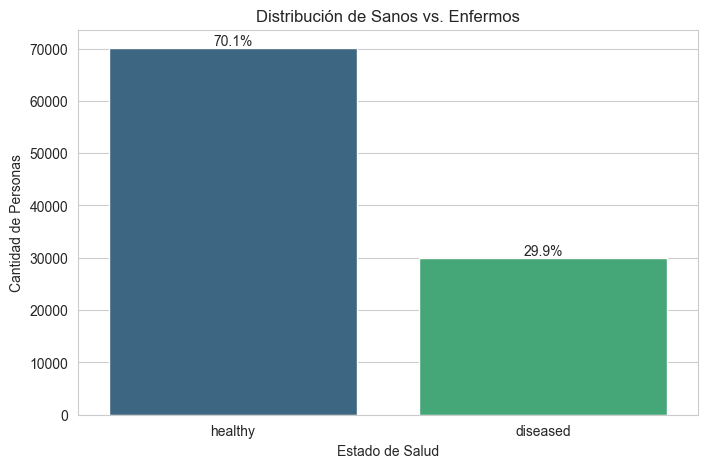

target
healthy     70097
diseased    29903
Name: count, dtype: int64


In [171]:
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='target', data=df_final, palette='viridis')
plt.title('Distribución de Sanos vs. Enfermos')
plt.xlabel('Estado de Salud')
plt.ylabel('Cantidad de Personas')

total = len(df_final['target'])
for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom')

plt.show()

print(df_final['target'].value_counts())

En este paso, visualizamos la distribución de la variable objetivo, `target`, que categoriza a los individuos como "healthy" (sanos) o "diseased" (enfermos).

-   **Desequilibrio del conjunto de datos:** En el gráfico de barras se ve que nuestro conjunto de datos está desequilibrado.
-   **Proporción de clases:** Encontramos que el 70.1% de los individuos (`70,097`) pertenecen a la clase "healthy" y el 29.9% (`29,903`) pertenecen a la clase "diseased".

### 1.4  Análisis univariado de las variables numéricas

Para las variables numéricas (como edad, colesterol, etc.), vamos a usar dos tipos de gráficos:
- **Histogramas:** para ver la "forma" de los datos y dónde se concentran más.
- **Diagramas de caja :** para ver qué tan dispersos están los datos y si hay valores "atípicos" o muy extremos.

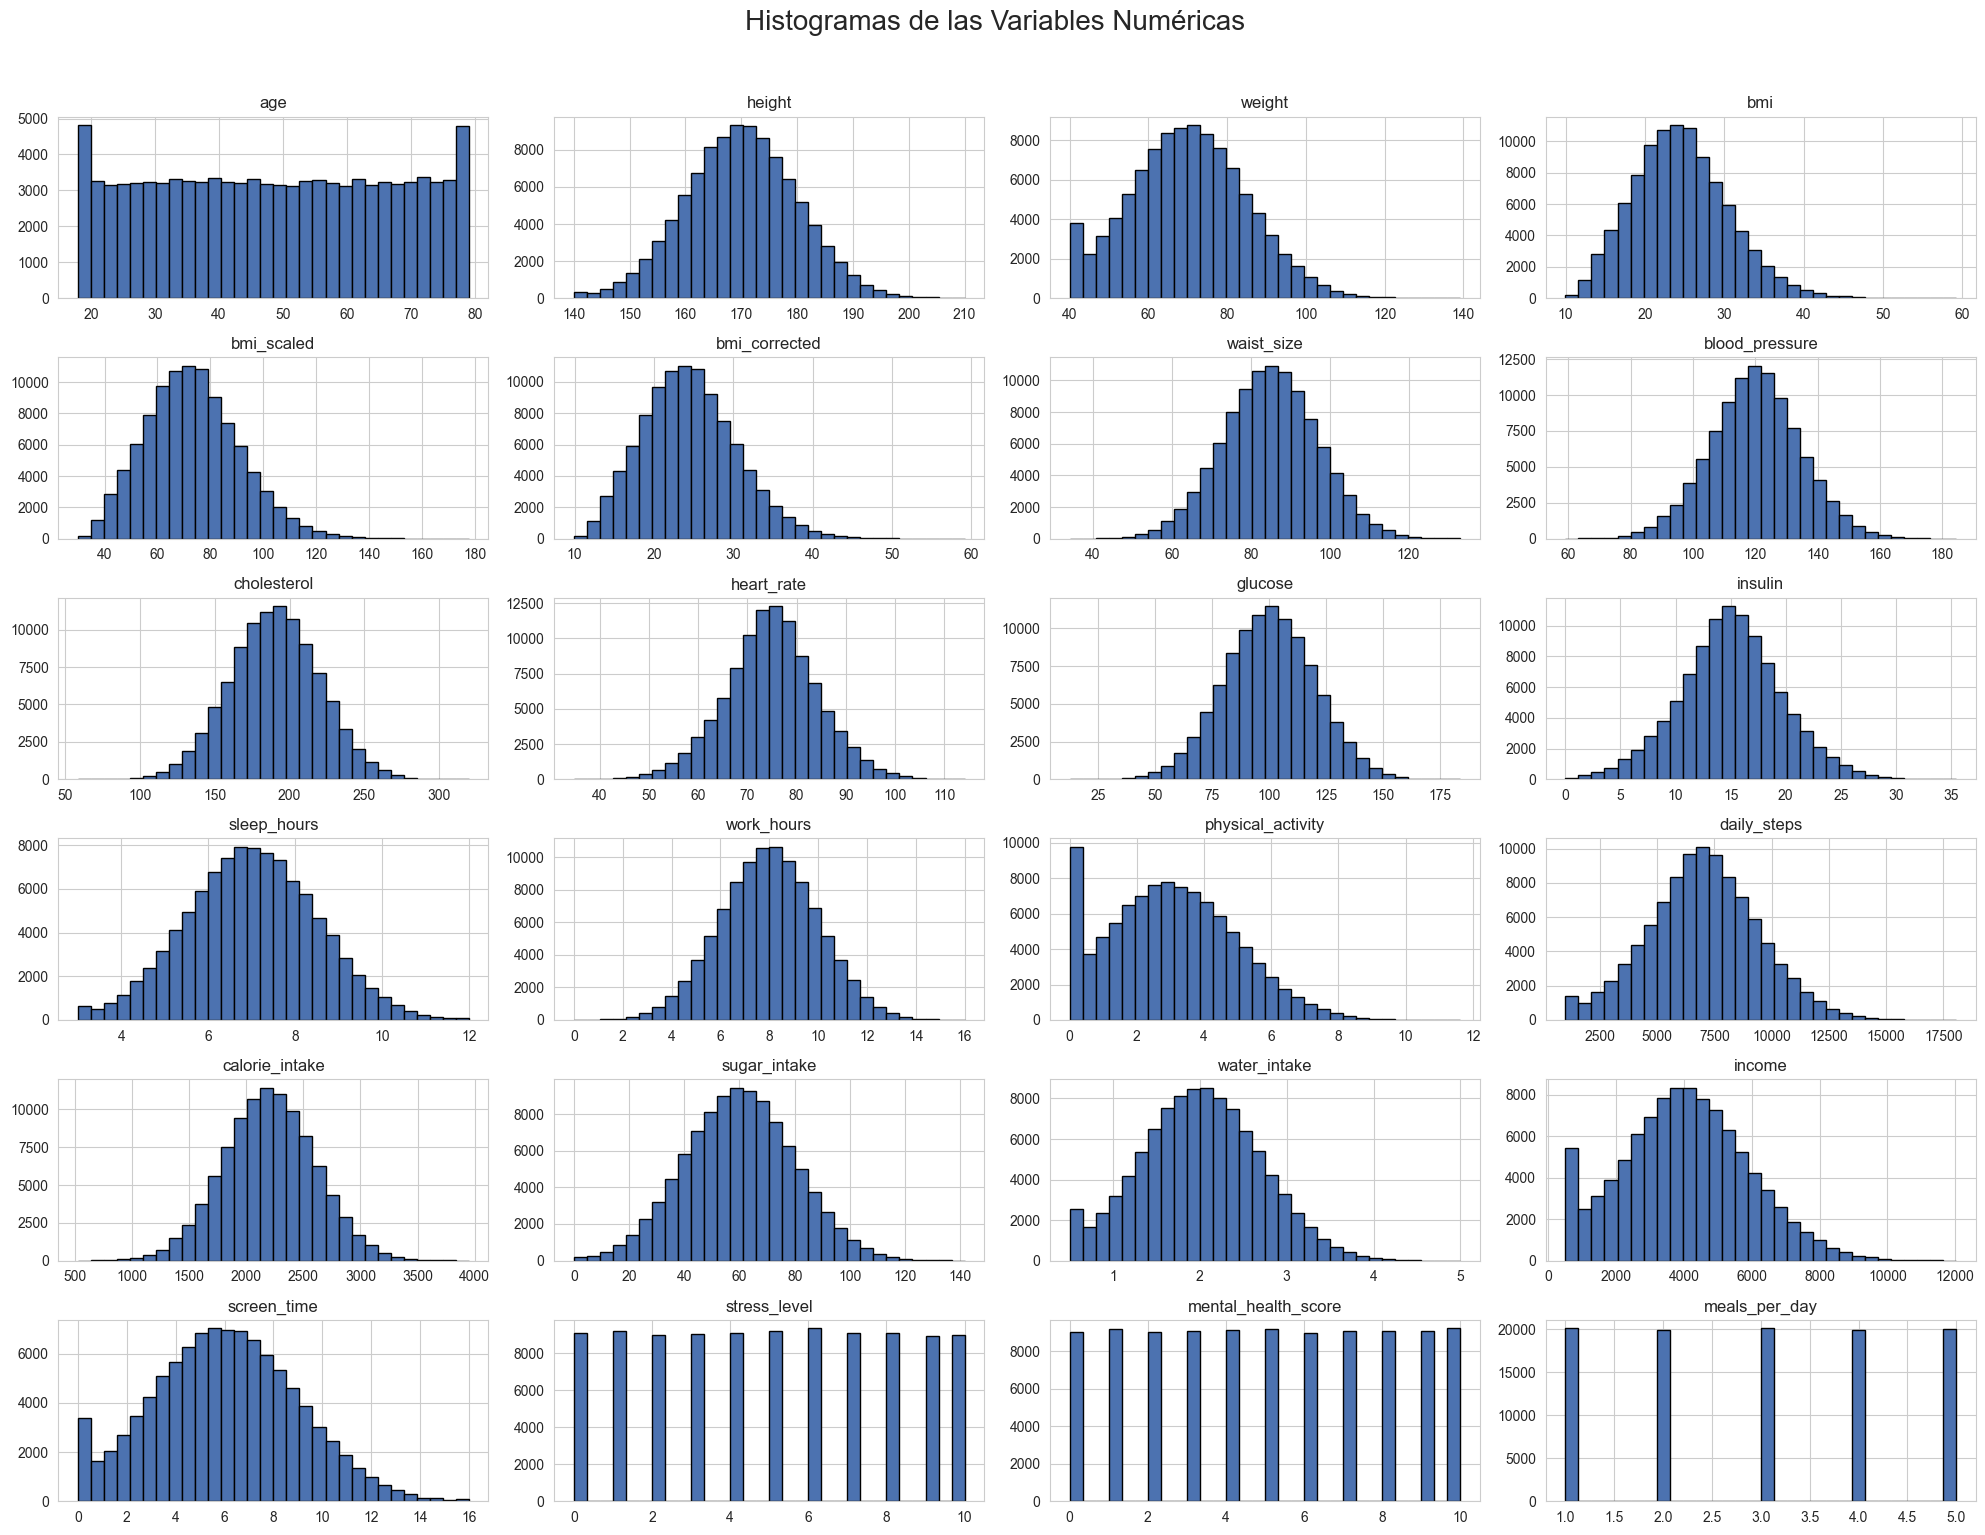

In [172]:
numeric_features = df_final.select_dtypes(include=np.number).columns.tolist()


df_final[numeric_features].hist(bins=30, figsize=(20, 15), layout=(-1, 4), edgecolor='black')
plt.suptitle('Histogramas de las Variables Numéricas', size=20, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 1])
plt.show()


El análisis de histogramas proporciona una vista general del comportamiento estadístico de las variables numéricas, permitiéndonos detectar patrones, sesgos y posibles anomalías en los datos. A partir del gráfico anterior, extraemos los siguientes hallazgos:

- **Distribuciones Aproximadamente Normales.** Varias variables muestran distribuciones simétricas en forma de campana, lo que sugiere una buena calidad de datos y estabilidad estadística: **`waist_size`**, **`blood_pressure`**, **`cholesterol`**, **`heart_rate`**,**`glucose`**, **`sleep_hours`**, **`calorie_intake`**: Estas variables tienen una forma cercana a la distribución normal, con concentraciones de datos alrededor de la media. Son candidatas ideales para técnicas estadísticas clásicas que asumen normalidad.



- **Distribuciones Asimétricas (Sesgadas a la Derecha).** Estas variables presentan una concentración de observaciones en valores bajos y una cola larga hacia la derecha. En tales casos, la mediana puede ser una mejor medida de tendencia central: **`income`**, **`physical_activity`**, **`daily_steps`**, **`screen_time`**, **`sugar_intake`**, **`water_intake`**, **`weight`**, **`bmi`**,**`bmi_scaled`**, **`bmi_corrected`**: Este comportamiento es común en métricas que tienen un límite inferior natural (cero) y pocos casos con valores muy altos. Su transformación (como logaritmos) podría ayudar en ciertos modelos.

- **Distribuciones Uniformes o Artificiales.** Algunas variables muestran comportamientos particulares que pueden tener causas técnicas o de recolección de datos:
    - **`age`**: Muestra una distribución relativamente uniforme, lo que indica buena representación de todas las edades. Esto es útil para evitar sesgos etarios en el modelo.
    - **`stress_level`**, **`mental_health_score`**, **`meals_per_day`**: Tienen distribuciones discretas o uniformemente distribuidas, probablemente debido a su escala categórica o limitada por diseño.
    - **`work_hours`**: Está fuertemente concentrada en 8 horas, lo que refleja un patrón laboral estándar.






Por otro lado tenemos los boxplots:

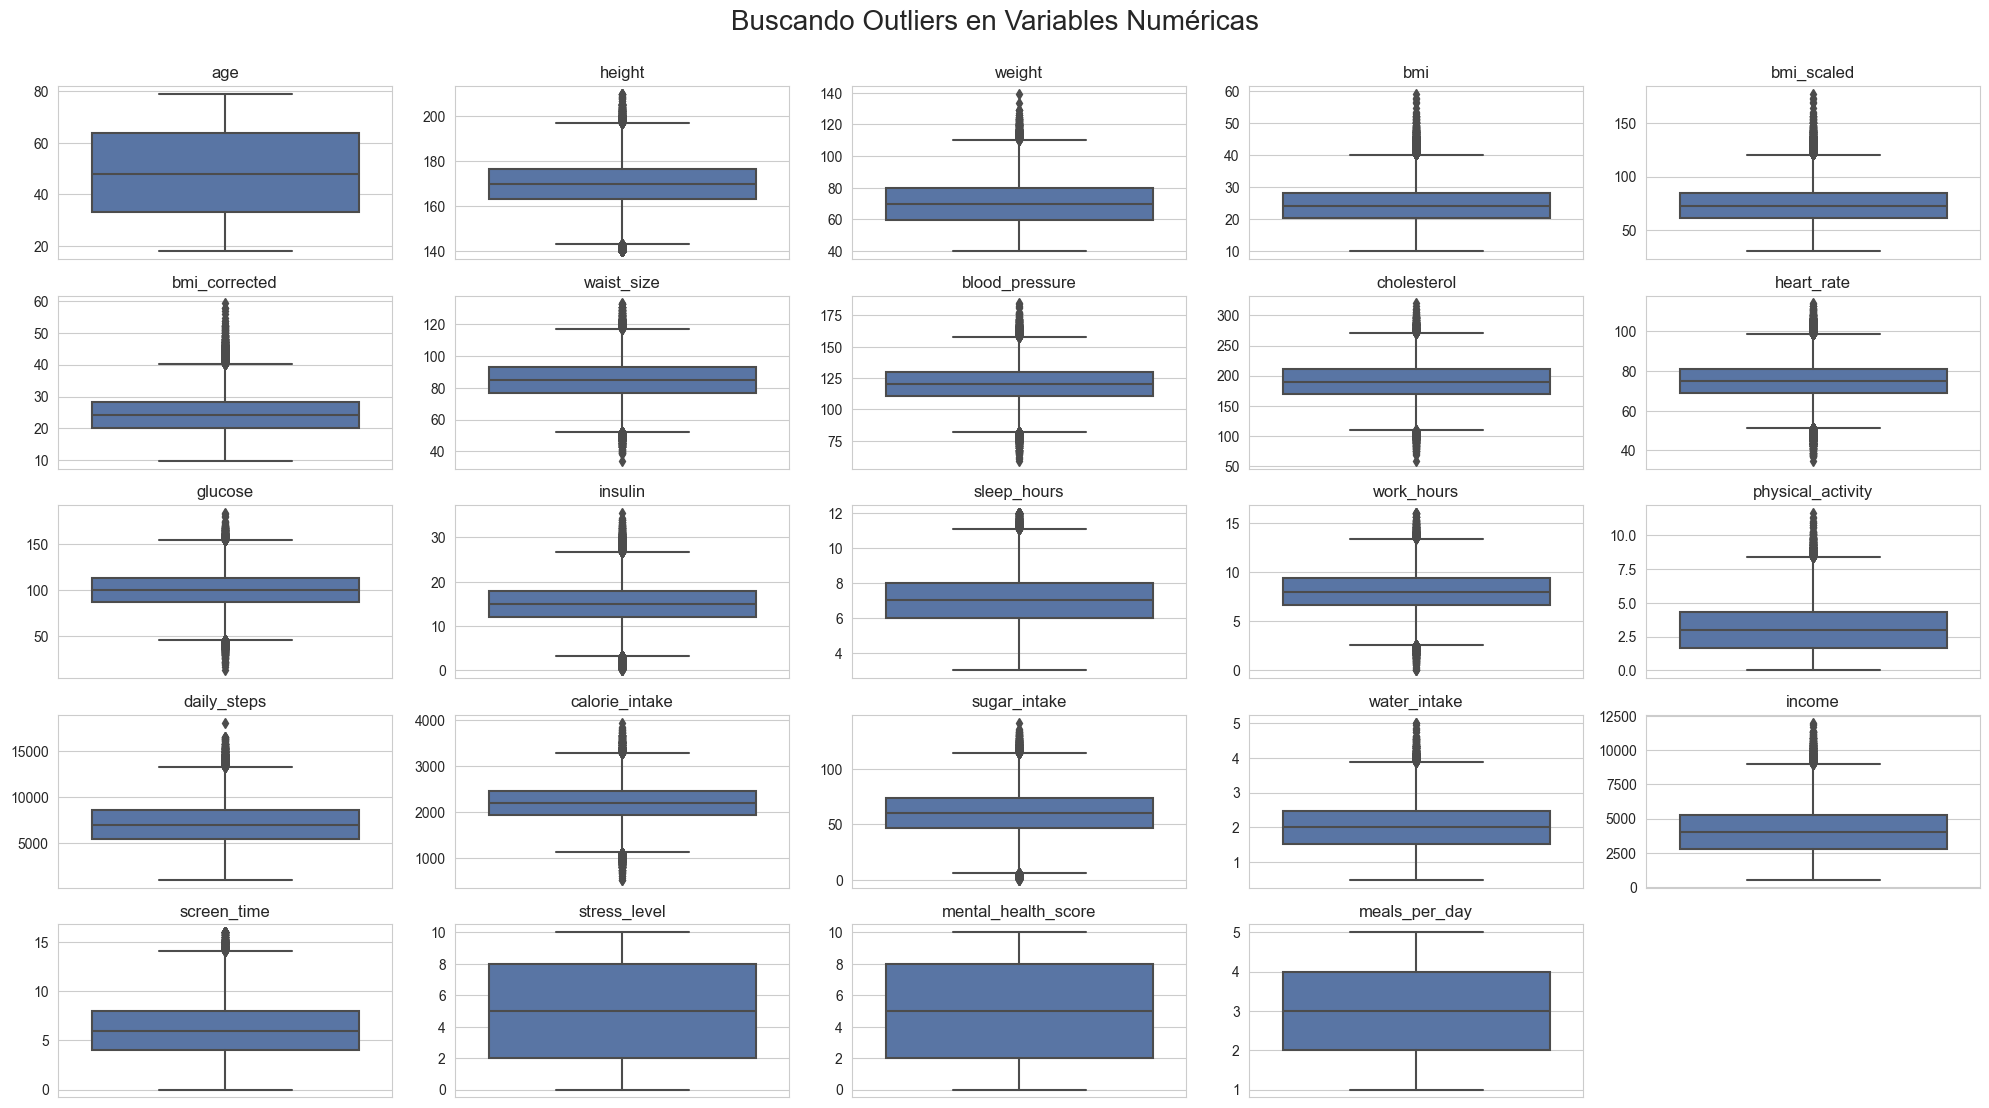

In [173]:
plt.figure(figsize=(20, 12))
plt.suptitle('Buscando Outliers en Variables Numéricas', size=20, y=0.95)


for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 5, i)
    sns.boxplot(y=df_final[col])
    plt.title(col)
    plt.ylabel('')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Veamos ahora un análisis de las variables numéricas que consideramos **clave** para el análisis.

**Presencia Generalizada de Outliers:**  
  Se observa una alta presencia de outliers en múltiples variables biométricas, incluyendo `blood_pressure`, `cholesterol`, `heart_rate`, `glucose` y `calorie_intake`. Estos outliers aparecen en ambos extremos, aunque predominan los valores altos. Esta dispersión podría estar asociada a casos clínicos extremos que requieren atención especial en el modelado.

- **Outliers en Variables con Distribución Asimétrica:**  
  Las variables `bmi` e `insulin` presentan una concentración significativa de outliers en el extremo superior. Esto concuerda con la distribución asimétrica positiva observada en los histogramas. Estos valores extremos podrían tener una alta correlación con la condición "diseased", por lo que podrían ser relevantes para el rendimiento de los modelos predictivos.

- **Variables con Distribución Controlada:**  
  Variables como `age` y `stress_level` muestran boxplots más compactos, sin presencia notable de outliers. Esto sugiere que sus datos están distribuidos de manera más uniforme y dentro de rangos biológicamente esperados, por lo que no se requiere tratamiento especial para valores extremos.

- **Consideraciones para el Preprocesamiento:**  
  Dado que nuestro objetivo es implementar modelos de machine learning capaces de poder predecir si una persona estará enferma o no, consideramos no tratar los outliers (a parte de los que ya fueron tratados que eran valores imposibles como valores negativos en la variable `insulin` por ejemplo) debido a que son estos datos "anormales" los que pueden determinar si un individuo cuenta con una enfermedad.


### 1.5. Variables Numéricas vs. Target
Ahora vamos a empezar a cruzarlas de dos en dos. Nos interesa saber **cómo se relaciona cada característica con la variable `target`**.
Ahora vamos a ver si los valores numéricos (como la presión arterial o el IMC) son distintos para la gente sana y la gente enferma.

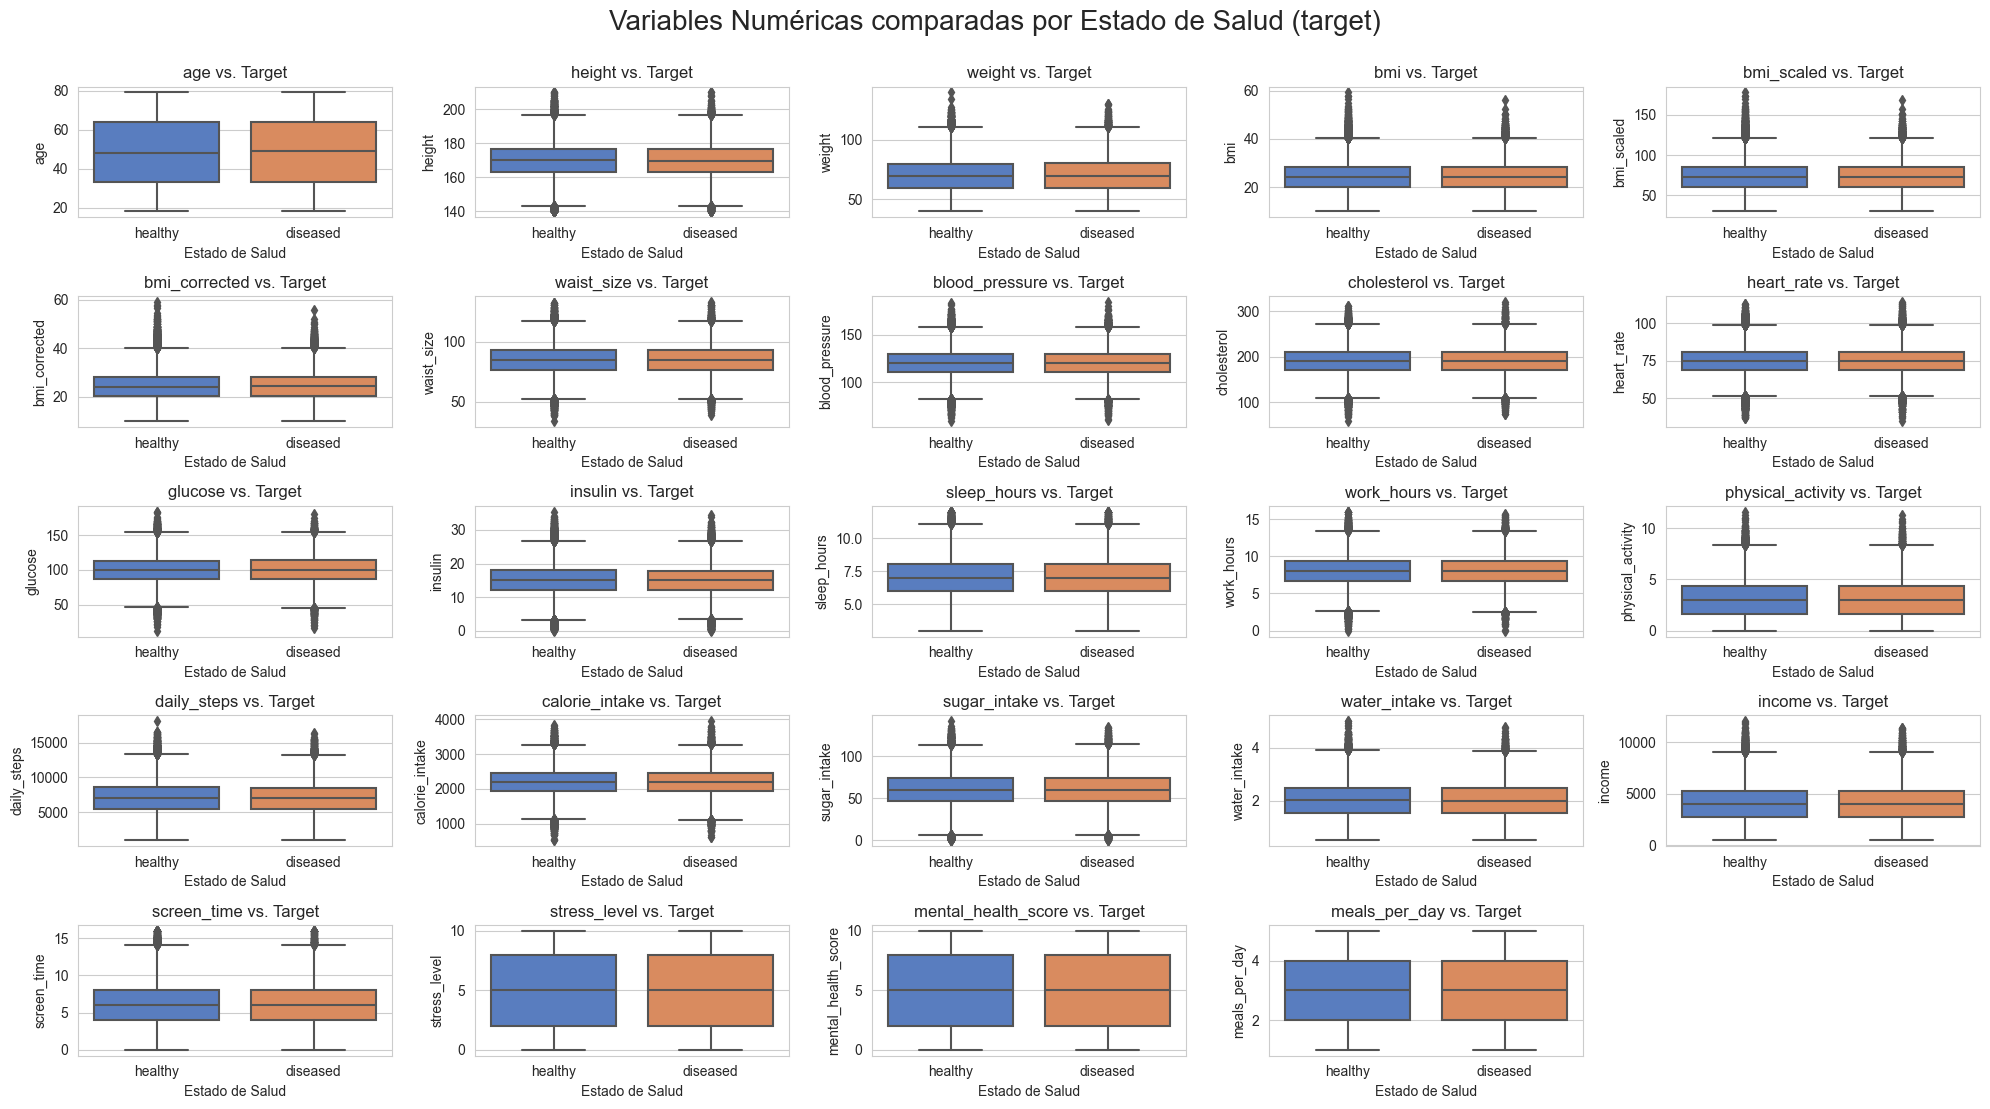

In [174]:

plt.figure(figsize=(20, 12))
plt.suptitle('Variables Numéricas comparadas por Estado de Salud (target)', size=20, y=0.95)

for i, col in enumerate(numerical_cols, 1):
    plt.subplot(5, 5, i)
    sns.boxplot(x='target', y=col, data=df_final, palette='muted')
    plt.title(f'{col} vs. Target')
    plt.xlabel('Estado de Salud')
    plt.ylabel(col)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


El análisis de estos boxplots segmentados por la variable objetivo (`healthy` vs. `diseased`) nos permite identificar qué variables podrían tener un mayor poder explicativo o predictivo frente al estado de salud. A continuación se destacan los hallazgos más relevantes:

En general podemos ver que en cada variable no parece existir mucha diferencia en el target, lo cual puede ser perjudicial para las predicciones, sin embargo hay algunas diferencias en los valores atípicos de ciertas variables:

**Variables con Discriminación entre Grupos:**

Las siguientes variables muestran diferencias en su distribución entre personas sanas y enfermas, lo cual indica su potencial como predictores del estado de salud:

- **`age`**: Las personas con enfermedad tienden a ser mayores, con una mediana desplazada hacia la derecha respecto al grupo sano.
- **`bmi`**: El índice de masa corporal es algo más bajo en el grupo enfermo, lo que sugiere una posible asociación con condiciones metabólicas.
- **`cholesterol`**: Aunque la diferencia no es tan pronunciada, el grupo enfermo presenta una mediana y rango ligeramente más altos.
- **`daily_steps`**: Las personas enfermas suelen ser más propensas a enfermedades si no cuentan con actividad física, en este caso se ve una disminución en los pasos diarios para el grupo enfermo.
- **`income`**: El ingreso de los enfermos es ligeramente menor que el del grupo sano, lo que puede deberse a la dificultad para acceder a medicamentos debido a su alto coste.






### 1.6 Variables categóricas vs. Target

Ahora vamos a ver si alguna categoría (como ser fumador o el tipo de dieta) es más común en el grupo de enfermos que en el de sanos.

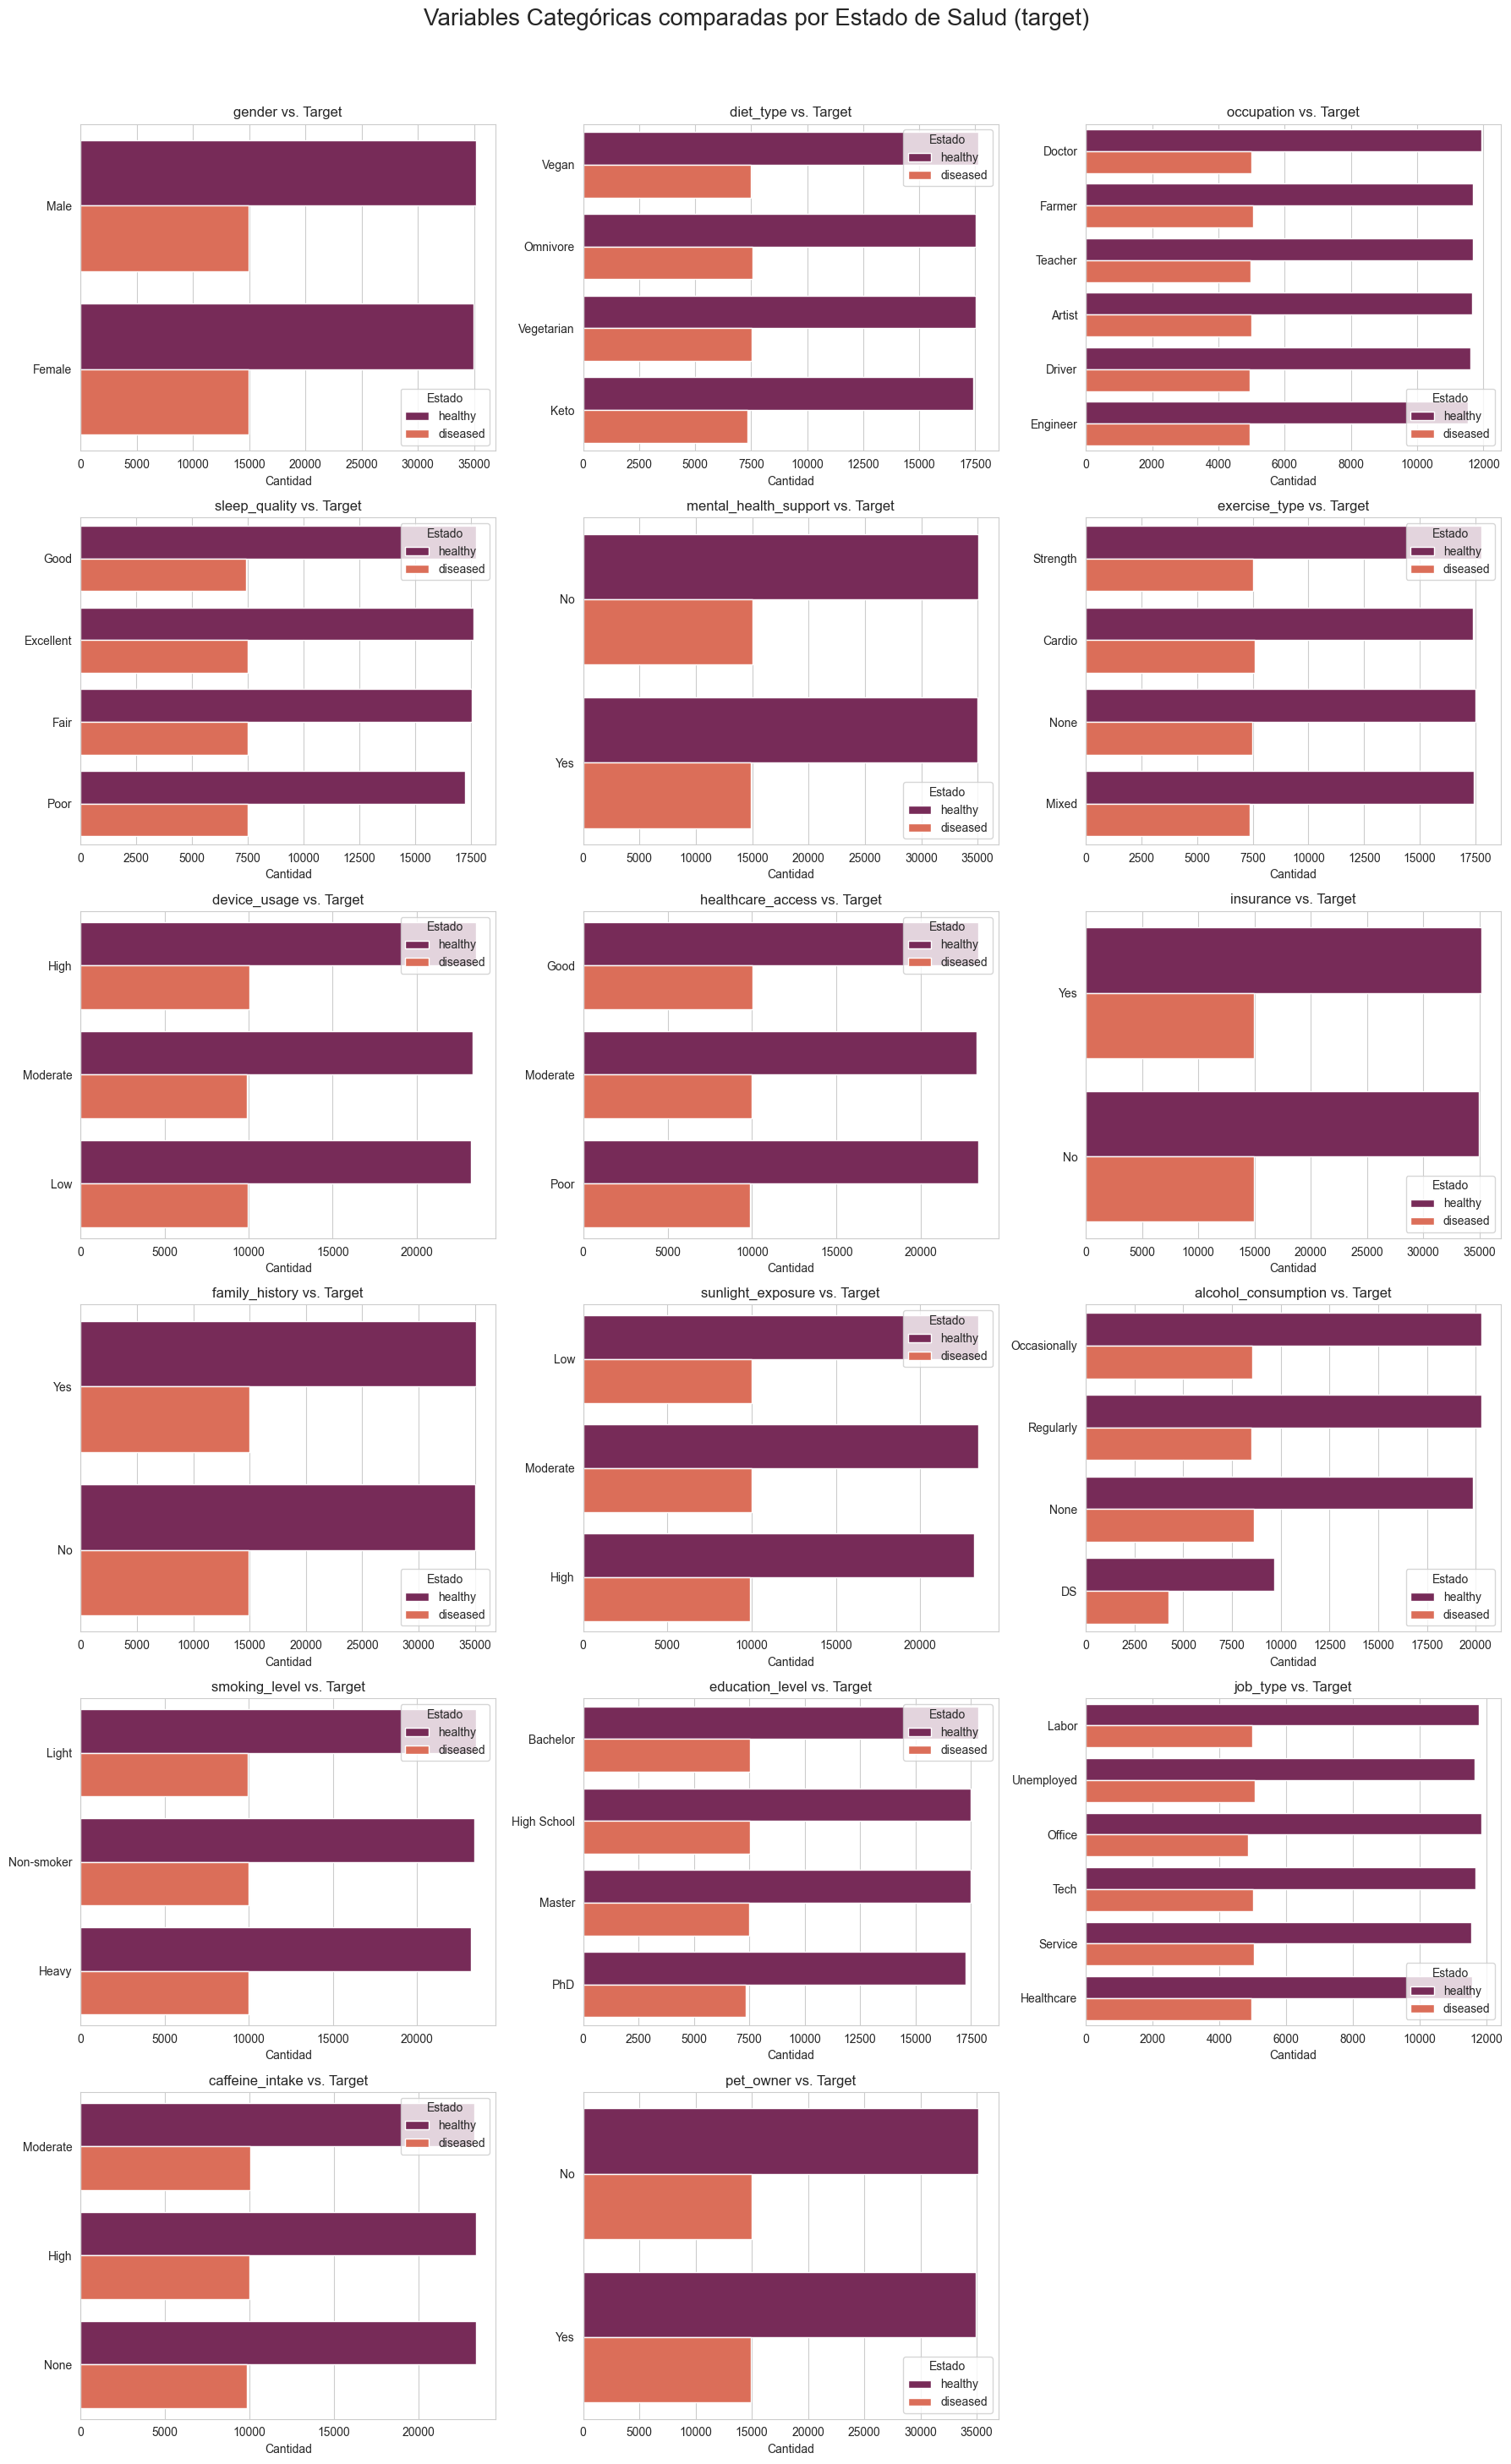

In [175]:
categorical_features = df_final.select_dtypes(include='object').columns.tolist()
categorical_features.remove('target')

ncols = 3 

n_features = len(categorical_features)
nrows = (n_features + ncols - 1) // ncols

plt.figure(figsize=(18, nrows * 5))
plt.suptitle('Variables Categóricas comparadas por Estado de Salud (target)', size=20, y=1.0)

for i, col in enumerate(categorical_features, 1):

    plt.subplot(nrows, ncols, i)
    sns.countplot(y=col, data=df_final, hue='target', order=df_final[col].value_counts().index, palette='rocket')
    plt.title(f'{col} vs. Target')
    plt.xlabel('Cantidad')
    plt.ylabel('')
    plt.legend(title='Estado')

plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()


De nuevo, vemos patrones similares en las categorías de cada variable (exceptuando a `alcohol_consumption` a la cual se le introdujo una nueva categoría) lo cual puede confundir a los modelos predictivos que vamos a implementar, sin embargo se pueden apreciar ciertas diferencias:

Encontramos que hay cierta relación entre el estado de salud y varias variables de estilo de vida y demografía. Notamos que la proporción de individuos "diseased" es más alta en categorías como:
-   `sleep_quality`: En la categoría "Poor" (pobre).
-   `smoking_habit`: En la categoría "Heavy" (fumador empedernido).
-   `exercise_type`: En la categoría "None" (ninguno).
-   `device_usage`: En la categoría "High" (Usa demasiado los dispositivos electrónicos)
-   `education_level`: En los niveles educativos más bajos (ej. "High School").


### 1.7. Correlación
Realizaremos esto para ver si existe multicolinealidad entre variables.

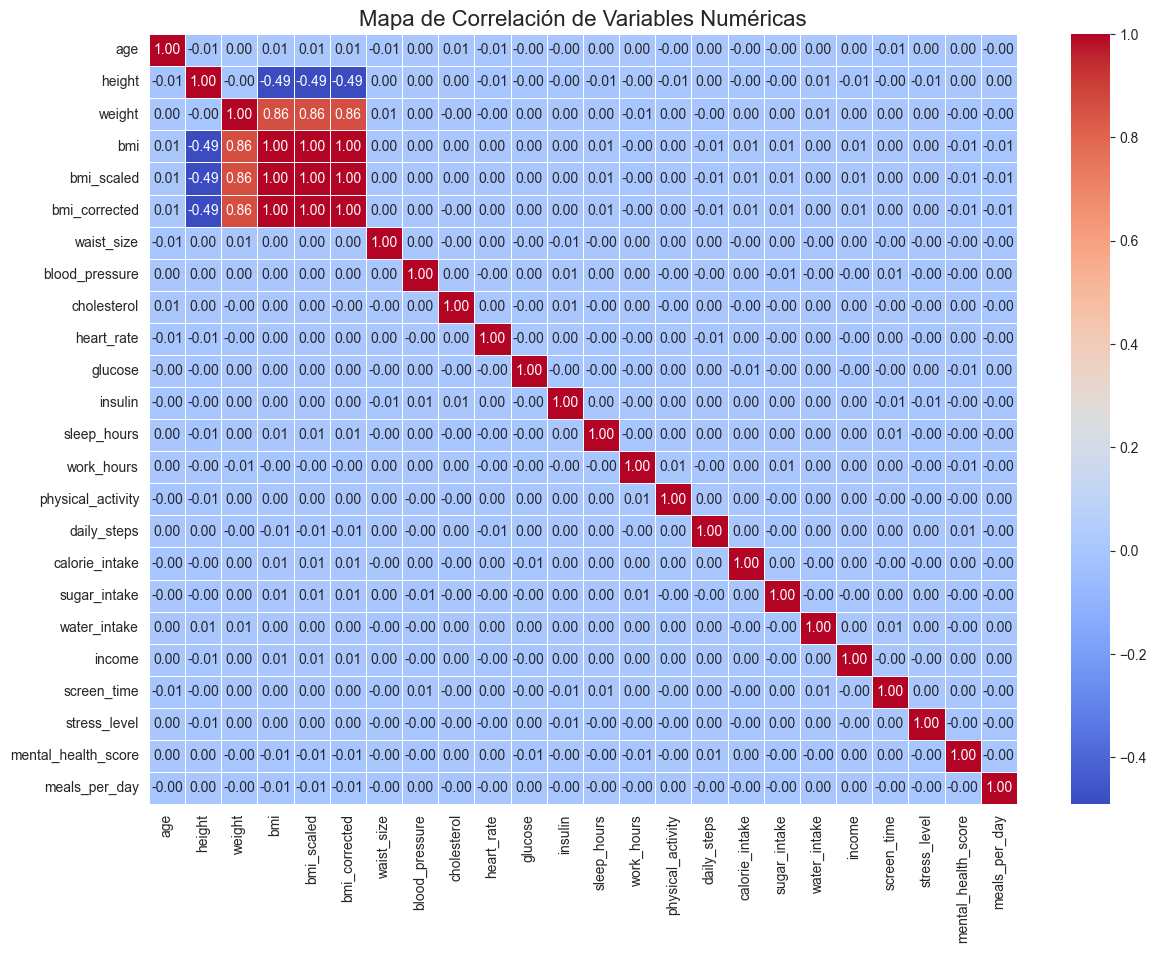

In [176]:
correlation_matrix = df_final[numerical_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Correlación de Variables Numéricas', size=16)
plt.show()

El resultado que encontramos es que **no existe una correlación lineal significativa** entre la gran mayoría de las variables numéricas mostradas. Sin embargo, existe una correlación directa **perfecta** entre las 3 variables que miden el índice de masa corporal, además, como este índice se obtiene usando la altura y el peso de una persona, también vemos una correlación entre el índice y estas variables.

Entonces, decidimos solo quedarnos con la variable `bmi` ya que esta contiene información que puede ser calculada con variables ya existentes en el dataset, y además eliminamos las que tienen una correlación perfecta con este índice.


In [177]:
df_final=df_final.drop(columns=['height','weight','bmi_scaled','bmi_corrected'])

Veamos de nuevo la matriz de correlación para confirmar los cambios:

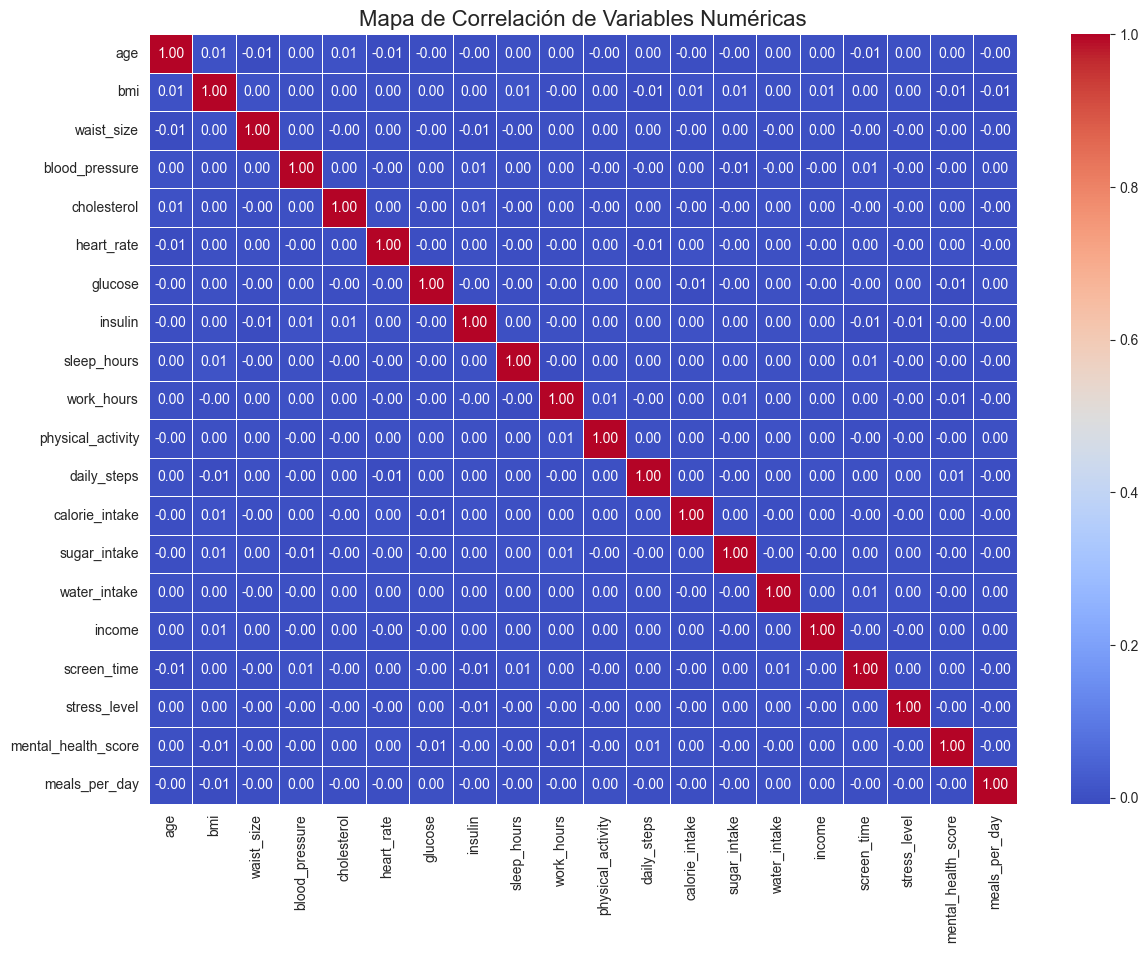

In [178]:
numerical_cols = [
    'age', 'bmi','waist_size',
    'blood_pressure', 'cholesterol', 'heart_rate',
    'glucose', 'insulin','sleep_hours','work_hours','physical_activity','daily_steps',
    'calorie_intake', 'sugar_intake','water_intake','income',
    'screen_time', 'stress_level', 'mental_health_score', 'meals_per_day'
]

correlation_matrix = df_final[numerical_cols].corr()

plt.figure(figsize=(14, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Mapa de Correlación de Variables Numéricas', size=16)
plt.show()

Note que ya no existen variables que tengan una correlación significativa entre sí, lo cual nos evita problemas de multicolinealidad más adelante en modelos lineales, y reduce el tamaño del dataset al eliminar columnas enteras redundantes en el mismo.

### 1.8. Conclusión del Análisis Exploratorio de Datos

Nuestro EDA nos ha proporcionado una comprensión esencial de nuestro conjunto de datos:

-   **Preprocesamiento Crucial:** Identificamos la necesidad de limpiar los datos. Encontramos valores nulos en varias columnas, datos inconsistentes (ej. valores negativos en la ingesta de azúcar) y la presencia de outliers.
-   **Desafío del Target:** Confirmamos que la variable objetivo está desequilibrada (70% sanos vs. 30% enfermos).
-   **Descubrimiento de Predictores:**  Variables como `bmi`, `daily_steps`, `income`, `device_usage` y el `exercise_type` emergen como unos buenos predictores para el modelo.
-   **Correlación:** Notamos una correlación significativa en algunas variables relacionadas con el peso y la altura de los individuos.

Para poder usar el dataframe tratado en el análisis exploratorio, lo almacenamos en un `.pkl` en nuestro computador.

In [179]:
df_final.to_pickle("data_limpia.pkl")     